In [209]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [210]:
# Load dataset
dataset = load_dataset("odegiber/hate_speech18", trust_remote_code=True)
df = dataset['train'].to_pandas()

In [211]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [212]:
df.columns

Index(['text', 'user_id', 'subforum_id', 'num_contexts', 'label'], dtype='object')

In [213]:
df=df.drop(columns=['user_id', 'subforum_id', 'num_contexts'], axis=1)
df.tail()

,text,label
10939,"Billy - `` That guy would n't leave me alone ,...",0
10940,Wish we at least had a Marine Le Pen to vote f...,0
10941,Its like the choices are white genocide candid...,0
10942,Why White people used to say that sex was a si...,1
10943,Now I get it !,0


In [214]:
df = df[(df['label'] == 0) | (df['label'] == 1)]

In [215]:
df['label'].value_counts()

label
0    9465
1    1193
Name: count, dtype: int64

In [216]:
# Text preprocessing
stopword = set(stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

In [217]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'&lt;.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    words = text.split()
    words = [word for word in words if word not in stopword]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)
df['clean_text'] = df['text'].apply(clean_text)

In [218]:
# Tokenization and padding
max_num_words = 10000
max_sequence_length = 70
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [219]:
# Label encoding and one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])
y = to_categorical(y_encoded)

In [220]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y_encoded, random_state=42
)

In [221]:
# Compute class weights (using original y_encoded for train set)
train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

In [222]:
# Optional: adjust class 0 weight if needed
class_weights[0] = class_weights[0] * 0.15
class_weights_dict = dict(enumerate(class_weights))

In [223]:
# Build model with Bidirectional LSTM
model = Sequential([
    Embedding(input_dim=max_num_words, output_dim=128, input_length=max_sequence_length),
    LSTM(64, dropout=0.5, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='sigmoid')  # 2 classes
])

/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [224]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [225]:
# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


In [226]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.1361 - loss: 0.2764 - val_accuracy: 0.1621 - val_loss: 1.6140
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 104ms/step - accuracy: 0.3256 - loss: 0.1688 - val_accuracy: 0.6432 - val_loss: 0.8708
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.7419 - loss: 0.0912 - val_accuracy: 0.6991 - val_loss: 0.7780
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.8427 - loss: 0.0639 - val_accuracy: 0.7107 - val_loss: 0.9119
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8810 - loss: 0.0489 - val_accuracy: 0.7722 - val_loss: 0.8709
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9124 - loss: 0.0378 - val_accuracy: 0.7426 - val_loss: 0.9373


In [227]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6977 - loss: 0.8000
Test Loss: 0.7779990434646606
Test Accuracy: 0.699061930179596


In [228]:
# Predictions and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_classes)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test_labels, y_pred_classes))

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Confusion Matrix:
 [[1641  726]
 [  76  222]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80      2367
           1       0.23      0.74      0.36       298

    accuracy                           0.70      2665
   macro avg       0.59      0.72      0.58      2665
weighted avg       0.88      0.70      0.75      2665



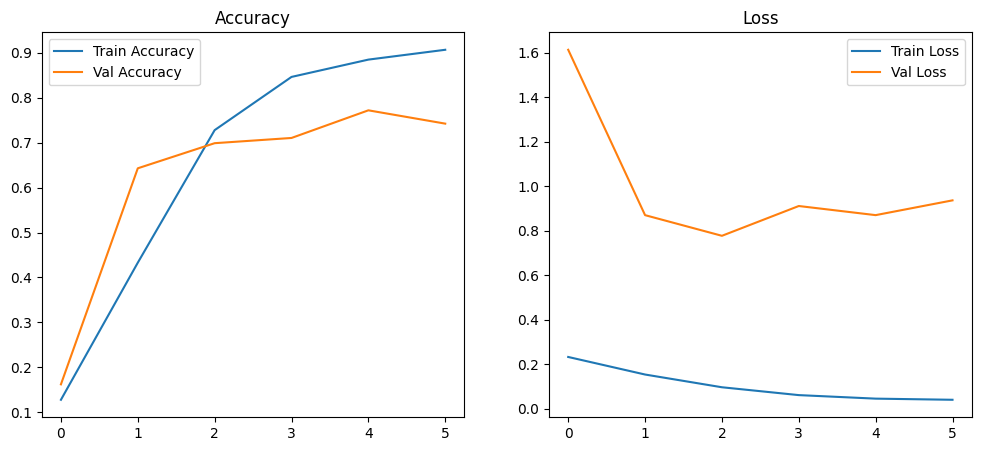

In [229]:
# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [230]:
# Prediction function
class_labels = ["No Hate", "Hate"]
def predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_sequence_length)
    pred = model.predict(padded)
    predicted_index = np.argmax(pred)
    predicted_label = class_labels[predicted_index]
    predicted_probs = pred.flatten()
    print("\n📊 Class probabilities:")
    for i, prob in enumerate(predicted_probs):
        print(f"  {class_labels[i]}: {prob:.4f}")
    return f"\n🧠 Predicted class: {predicted_label} (index: {predicted_index})"


In [231]:
print(df[df["label"]==1].sample(5)["text"].values[0])

ye i heard that one to. or ' we all came from Africa any way so why dose it matter ' ........ my answer ? ' we evolved to be better'


In [233]:
# Example usage

custom_input = "we evolved to be better"
print("Predicted class:", predict_text(custom_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

📊 Class probabilities:
  No Hate: 0.0791
  Hate: 0.9186
Predicted class: 
🧠 Predicted class: Hate (index: 1)
